<a href="https://colab.research.google.com/github/GoKarolis/DL_training_leaves_classification/blob/main/KG_FastAI2_0_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About the project:

Problem:

Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

Objectives:

To train a model using images of training dataset to:
 1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 
 2) Accurately distinguish between many diseases, sometimes more than one on a single leaf; 
 3) Deal with rare classes and novel symptoms; 
 4) Address depth perception—angle, light, shade, physiological age of the leaf; and 
 5) Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.


More info about the idea:

https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview

## INIT:

In [ ]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 14.2MB/s 
     |████████████████████████████████| 1.2MB 27.5MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 204kB 52.0MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [ ]:
# !pip freeze

In [ ]:
path = Path('/content/gdrive/MyDrive/Kaggle')
Path.BASE_PATH = path
path.ls()

(#5) [Path('train.csv'),Path('sample_submission.csv'),Path('test.csv'),Path('kaggle.json'),Path('leaves_images')]

In [ ]:
images_path = path/"leaves_images"

## EDA:

In [ ]:
(images_path).ls()

(#1821) [Path('leaves_images/Healthy_1698.jpg'),Path('leaves_images/Rust_1725.jpg'),Path('leaves_images/Healthy_1733.jpg'),Path('leaves_images/Rust_1712.jpg'),Path('leaves_images/Scab_172.jpg'),Path('leaves_images/Rust_1740.jpg'),Path('leaves_images/Healthy_1774.jpg'),Path('leaves_images/Rust_1785.jpg'),Path('leaves_images/Healthy_1777.jpg'),Path('leaves_images/Scab_1767.jpg')...]

In [ ]:
# dls = get_dls(64, 224)

In [ ]:
leaves_data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(flip_vert=True, mult=2, size=224, min_scale=0.75))
dls = leaves_data.dataloaders(images_path)

In [ ]:
dls.vocab

['Healthy', 'Multiple_diseases', 'Rust', 'Scab']

In [ ]:
dls.dataset

(#1457) [(PILImage mode=RGB size=2048x1365, TensorCategory(3)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(0)),(PILImage mode=RGB size=2048x1365, TensorCategory(3)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(3)),(PILImage mode=RGB size=2048x1365, TensorCategory(3)),(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(1))...]

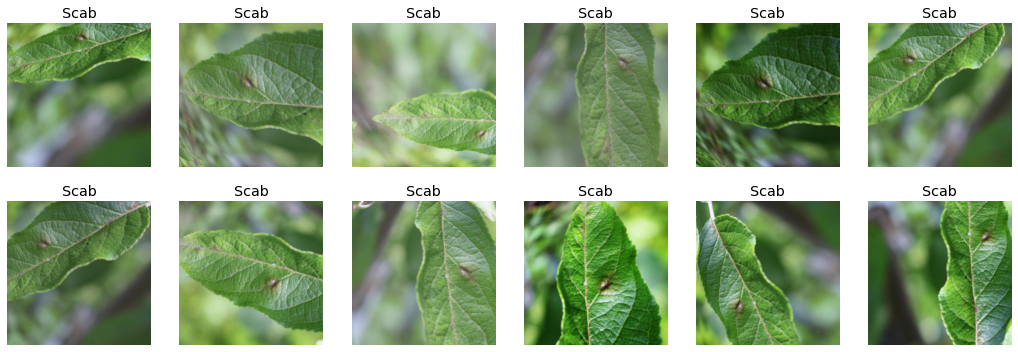

In [ ]:
dls.show_batch(max_n=12, nrows=2 ,unique=True)

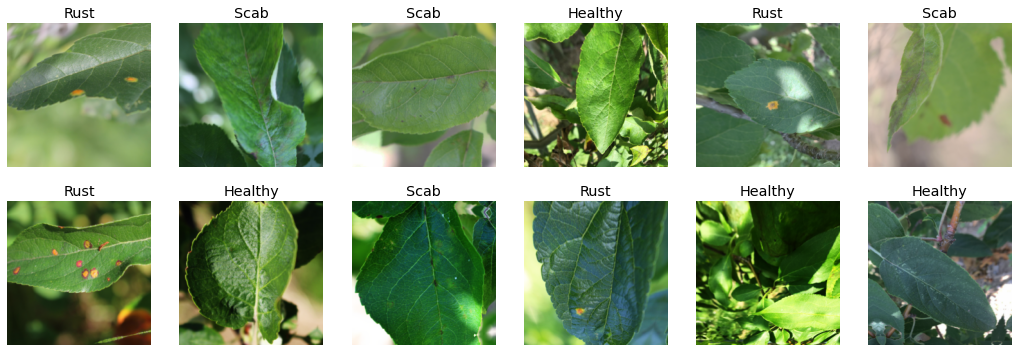

In [ ]:
dls.show_batch(max_n=12, nrows=2) # ,unique=True)

In [ ]:
leaves_data.summary(images_path)

Setting-up type transforms pipelines
Found 1821 items
2 datasets of sizes 1457,364
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/gdrive/MyDrive/Kaggle/leaves_images/Scab_806.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=2048x1365
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/gdrive/MyDrive/Kaggle/leaves_images/Scab_806.jpg
    applying partial gives
      Scab
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=2048x1365, TensorCategory(3))


Found 1821 items
2 datasets of sizes 1457,364
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline

## Data augmentation:

In [ ]:
# ResizeMethod.Crop
# aug_transforms(mult=2, size=224, min_scale=0.75))

Presizing:

In [ ]:
# item_tfms=Resize(460),
# batch_tfms=aug_transforms(size=224, min_scale=0.75)

In [ ]:
# interp.most_confused(min_val=5)

In [ ]:
# #width 600
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Try data on simple model:

Model interpretation:

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.659624,0.419807,0.151099,07:42


epoch,train_loss,valid_loss,error_rate,time
0,0.732816,0.276601,0.087912,01:16
1,0.639689,0.235190,0.076923,01:16
2,0.557320,0.183084,0.057692,01:16
3,0.459278,0.169176,0.060440,01:16


-------------------

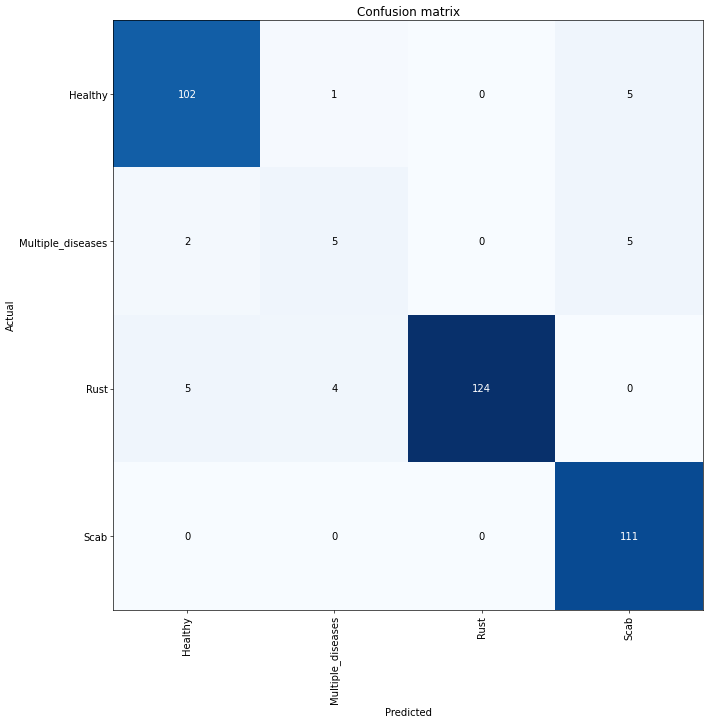

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=4)

[('Healthy', 'Scab', 5),
 ('Multiple_diseases', 'Scab', 5),
 ('Rust', 'Healthy', 5)]

Data cleaning:

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Model:

resnet18, 34, 50, 101, 152

Learning rate finder:

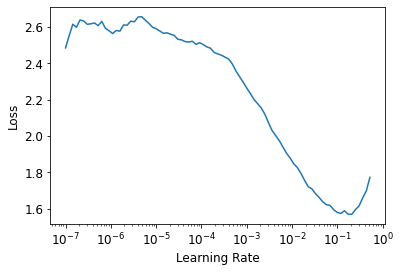

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
lr_min,lr_steep = learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(2, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.302561,0.505425,0.148352,01:42


epoch,train_loss,valid_loss,error_rate,time
0,0.626111,0.756509,0.118132,01:45
1,0.473600,0.262233,0.060440,01:46


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.009120108559727669)

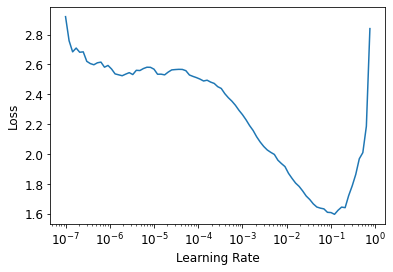

In [ ]:
learn.lr_find()

Discriminative Learning Rates:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.313252,0.360463,0.112637,01:47
1,0.809472,0.279424,0.107143,01:47
2,0.597461,0.286345,0.087912,01:48


epoch,train_loss,valid_loss,error_rate,time
0,0.335585,0.280224,0.076923,01:54
1,0.295347,0.249263,0.074176,01:52
2,0.276671,0.235719,0.071429,01:54
3,0.246793,0.246936,0.076923,01:53
4,0.213709,0.210575,0.052198,01:52
5,0.177914,0.205942,0.068681,01:53
6,0.164495,0.203248,0.065934,01:53
7,0.143918,0.187486,0.049451,01:51
8,0.127415,0.193667,0.052198,01:52
9,0.113695,0.186063,0.052198,01:51


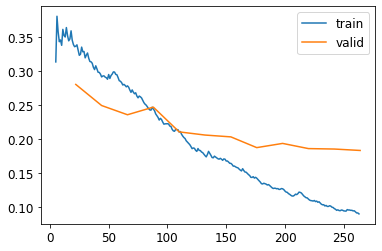

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp.plot_top_losses(5, nrows=2)

NameError: ignored

## Progressive Resizing:

In [ ]:
dls = get_dls(128, 128)

learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.440253,1.951594,0.354396,04:55
1,1.406707,1.601084,0.456044,01:19
2,1.251066,0.857755,0.692308,01:19
3,1.132623,0.885124,0.670330,01:19


In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.871378,0.915509,0.664835,01:22


epoch,train_loss,valid_loss,accuracy,time
0,0.765545,0.637034,0.780220,01:24
1,0.706459,0.613305,0.774725,01:23


## To do:

1. Transfer learning
2. Smoothing
3. Center or Squish
4. Find learning rate
5. EDA




## Notes




*   If the training loss is higher than val loss - you are underfitting
  If underfitting: train longer, lower lr, 
*   www.neuralnetworksanddeeplearning.com
*   batchnormos ir tik tada dropoutas
*   FastAI, lr, slice lr, touple lr
*   Deep learning with PyTorch
* Pytorch dokumentacija

Questions
* How to choose best Base for my model?
* For imgages:
  NASNET
  Xception (Universali) (Francua Collet(?)) (Pytorche neveiks gerai) (Pradėti nuo jo)
  EfficientNet (veikia gerai visur) (Pradžiai naudoti B1)
  
* For timed series: Facebook Prophet, Pytorch Forecasting, GlonTS.

Fastai lesson 5:
* Discrimative learning rates (split the model into two parts, use different lr)
*




mask
batch
batchnorm
lr
higher order functions


### CSV data input:

In [ ]:
# path = Path("../input")
# labels = pd.read_csv(path/"train_labels.csv")
# labels.head()

In [ ]:
# np.random.seed(123)
# sz = 32
# data = ImageDataBunch.from_csv(path, folder = 'train', csv_labels = "train_labels.csv",
#                                test = 'test',suffix=".tif", size = sz,bs = 256,
#                                ds_tfms = tfms)
# data.path = pathlib.Path('.')
# data.normalize(imagenet_stats)

Pypelines:

In [ ]:
def get_dls(bs, size):
    leaves_data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return leaves_data.dataloaders(images_path, bs=bs)

Other:

In [ ]:
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.0.

In [ ]:
# !pip install -q --upgrade ipython==5.5.0
# !pip install -q --upgrade ipykernel==4.10